In [2]:
import pandas as pd
import numpy as np
import Utils
import tensorflow as tf
import keras
import pickle

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import Concatenate
from keras.layers import LSTM
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Reshape
from keras.models import Model, load_model
from keras.utils import to_categorical

# import nltk
# nltk.download('stopwords')

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import unicodedata
import re
import gc

In [2]:
def load_W2V_model(path):
    model = KeyedVectors.load_word2vec_format(path, binary=True)
    print("Loaded W2V model")
    return model

def load_data(path):
    df = pd.read_csv(path, sep='\t', index_col=0)
    print("Loaded dataset:", path)
    return df

def review_to_wordlist(raw_review, stemmer=False):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove accent marks
    review_text = ''.join((c for c in unicodedata.normalize('NFD',str(raw_review)) if unicodedata.category(c) != 'Mn'))
    #
    # 2. Remove non-letters
    #letters_only = re.sub("[^A-Za-z0-9]", " ", review_text) 
    letters_only = re.sub("[^\w\d]", " ", review_text) 
    #
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 3. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("spanish"))                  
    # 
    # 4. Remove stop words and apply or not stemming
    if stemmer:
        meaningful_words = [stemmer.stem(w) for w in words if not w in stops]
    else:
        meaningful_words = [w for w in words if not w in stops]
    #
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    #return( " ".join( meaningful_words ))
    return meaningful_words

In [3]:
path_w2v_hufa = "./W2V/hufa_stem-300-5w-10n-skip.bin"
path_w2v_wiki = "./W2V/sbw_vectors.bin"
path_data_train = "./hufa_train_stem_skip/train"
path_data_test = "./hufa_test_stem_skip/test"
path_data_dev = "./hufa_dev_stem_skip/dev"

MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 2000
#MAX_SEQUENCE_LENGTH = 2000

stemmer = SnowballStemmer('spanish')
model = load_W2V_model(path_w2v_hufa)
df_train = load_data(path_data_train)
df_test = load_data(path_data_test)
df_dev = load_data(path_data_dev)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

Loaded W2V model
Loaded dataset: ./hufa_train_stem_skip/train
Loaded dataset: ./hufa_test_stem_skip/test
Loaded dataset: ./hufa_dev_stem_skip/dev


In [6]:
len(df_train), len(df_dev), len(df_test)

(131940, 32986, 54976)

In [17]:
len(df_test[df_test.label == False])

54473

In [5]:
Xtrain = [review_to_wordlist(text, stemmer) for text in df_train.text]
Ytrain = np.asarray(df_train.label)
Xdev = [review_to_wordlist(text, stemmer) for text in df_dev.text]
Ydev = np.asarray(df_dev.label)
Xtest = [review_to_wordlist(text, stemmer) for text in df_test.text]
Ytest = np.asarray(df_test.label)
texts = Xtrain+Xdev+Xtest

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


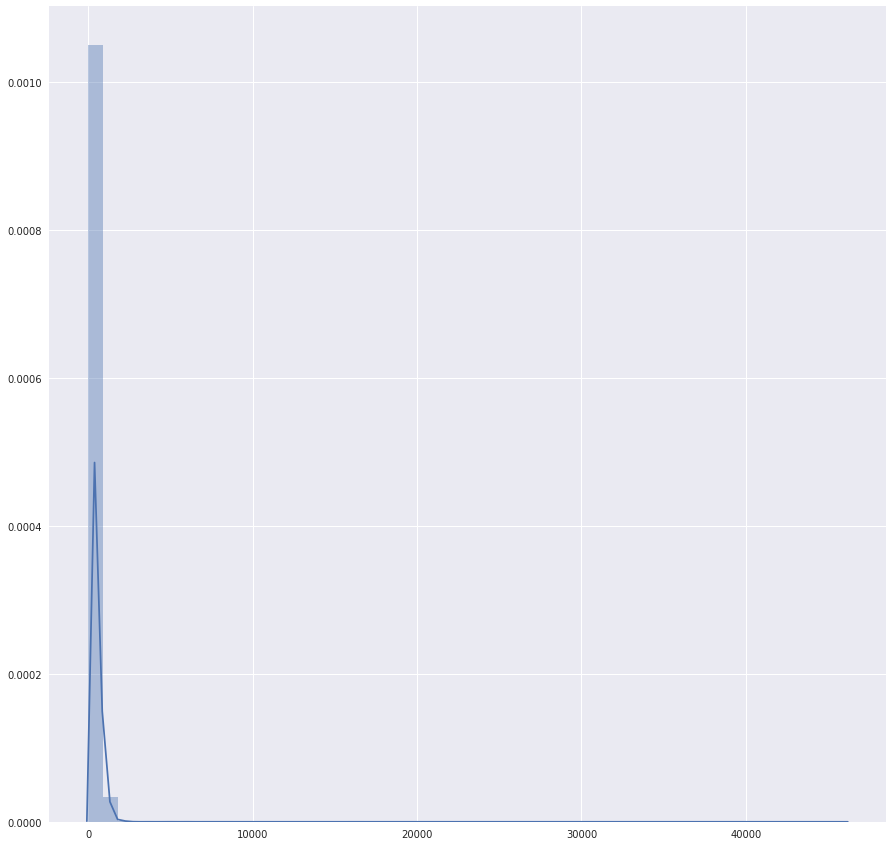

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.subplots(figsize=(15,15))
sns.set(color_codes=True)
x = np.asarray([len(t) for t in texts])
sns.distplot(x,);

In [6]:
tokenizer.fit_on_texts(texts)

sequences_train = tokenizer.texts_to_sequences(Xtrain)
sequences_dev = tokenizer.texts_to_sequences(Xdev)
sequences_test = tokenizer.texts_to_sequences(Xtest)
del Xtrain, Xdev, Xtest

In [7]:
# train 80% - dev 20%
mitad = int(len(sequences_train)/2)
Xdev = pad_sequences(sequences_dev, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='pre', dtype='int16')
Xtrain = pad_sequences(sequences_train[:mitad], maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='pre', dtype='int16')
Xtrain = np.concatenate((Xtrain, pad_sequences(sequences_train[mitad:], maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='pre', dtype='int16')))
Xtest = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='pre', dtype='int16')
del sequences_dev, sequences_train, sequences_test
gc.collect()

0

In [8]:
word_index = tokenizer.word_index
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM), dtype=np.float32)
for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in model:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = model[word]

In [9]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# class_W = class_weight.compute_class_weight('balanced', np.unique(np.asarray(df_train.label)), np.asarray(df_train.label))
# class_weight_dict = dict(enumerate(class_W))

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = 0
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(np.round(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]
        f1 = f1_score(targ, predict)
        print ("\nF1 on dev: "+str(f1)+"\n")
        if (self.f1s < f1):
            self.f1s = f1
            self.model.save('./model/Best_EMRS_model_f1_.hdf5')
            print("Modelo guardado\n")
        return
    
metrics = Metrics()

In [11]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int16')

embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 2, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
y = Conv1D(64, 3, activation='relu')(embedded_sequences)
y = GlobalMaxPooling1D()(y)
z = Conv1D(64, 5, activation='relu')(embedded_sequences)
z = GlobalMaxPooling1D()(z)

x = Concatenate()([x,y,z])

preds = Dense(1, activation='sigmoid')(x)
Conv_model = Model(sequence_input, preds)
print('compile')

Conv_model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=[Utils.precision,Utils.recall,Utils.fmeasure])

#filepath="./model/weights-improvement.hdf5"
callbacks_list = [metrics]

compile


In [12]:
print('fit')
Conv_model.fit(Xtrain, Ytrain,
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=200,
      epochs=50,
      callbacks=callbacks_list,
      validation_data=(Xtest, Ytest))

fit
Train on 131940 samples, validate on 54976 samples
Epoch 1/50
131940/131940 [==============================] - 2759s 21ms/step - loss: 0.0229 - precision: 0.4822 - recall: 0.4359 - fmeasure: 0.4508 - val_loss: 0.0053 - val_precision: 0.0105 - val_recall: 0.0096 - val_fmeasure: 0.0100

F1 on dev: 0.9512953367875647

Modelo guardado

Epoch 2/50
131940/131940 [==============================] - 2650s 20ms/step - loss: 0.0044 - precision: 0.7905 - recall: 0.7484 - fmeasure: 0.7621 - val_loss: 0.0035 - val_precision: 0.0105 - val_recall: 0.0096 - val_fmeasure: 0.0100

F1 on dev: 0.9523809523809524

Modelo guardado

Epoch 3/50
131940/131940 [==============================] - 2646s 20ms/step - loss: 0.0032 - precision: 0.7977 - recall: 0.7577 - fmeasure: 0.7704 - val_loss: 0.0031 - val_precision: 0.0105 - val_recall: 0.0097 - val_fmeasure: 0.0100

F1 on dev: 0.9557157569515963

Modelo guardado

Epoch 4/50
131940/131940 [==============================] - 2646s 20ms/step - loss: 0.0025 - pre

KeyboardInterrupt: 

In [4]:
Best_model = load_model('./model/Best_EMRS_model_f1.hdf5', custom_objects={'precision': Utils.precision, 'recall':Utils.recall, 'fmeasure':Utils.fmeasure})

In [33]:
result = np.round(Best_model.predict(Xtest))
print(classification_report(Ytest, result, digits=4))

             precision    recall  f1-score   support

      False     0.9993    0.9999    0.9996     54473
       True     0.9894    0.9264    0.9569       503

avg / total     0.9992    0.9992    0.9992     54976



In [16]:
del Conv_model
gc.collect()

2769

In [5]:
Best_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2000, 300)    6000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1999, 64)     38464       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1998, 64)     57664       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (